In [1]:
import matplotlib as mpl
from matplotlib.pyplot import *

# from fm import *
import time
import pickle
from scipy import constants
import numpy as np
from matplotlib.pyplot import cm
import pdb
from numba import jit
import math
import numpy as np
import scipy as sp
from array import *
from scipy import interpolate
from scipy import special
from scipy import interp
from scipy import ndimage
from astropy.io import fits
import pdb
import datetime
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"
import matplotlib.pyplot as plt

In [2]:
from POSEIDON.utility import read_high_res_data
from POSEIDON.high_res import fit_uncertainties
import numpy as np

data_dir = "./data/WASP-121b"
data = read_high_res_data(data_dir, method="sysrem")
data_raw = data["data_raw"]
uncertainties = data["uncertainties"]

In [31]:
from POSEIDON.high_res import fast_filter

data_norm = np.zeros(data_raw.shape)
for i in range(len(data_raw)):
    order = data_raw[i]
    out_of_transit_frames = np.concatenate((order[:20], order[-20:]), axis=0)
    median = np.median(out_of_transit_frames, axis=0)
    order_norm = order / median

    uncertainty = uncertainties[i]

    uncertainty_norm = uncertainty / median

    uncertainties[i] = uncertainty_norm
    data_norm[i] = order_norm

residuals, Us = fast_filter(data_norm, uncertainties, N_iter=15)

In [34]:
N_order, N_phi, N_wl = residuals.shape
Bs = np.zeros((N_order, N_phi, N_phi))

for j in range(N_order):
    U = Us[j]
    L = np.diag(1 / np.mean(uncertainties[j], axis=-1))

    # B = U @ np.linalg.inv((L @ U).T @ (L @ U)) @ (L @ U).T @ L
    B = U @ np.linalg.pinv(L @ U) @ L
    Bs[j] = B

In [5]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [10]:
from __future__ import absolute_import, unicode_literals, print_function
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import time

R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effective temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

F_s = star["F_star"]
wl_s = star["wl_star"]
R_s = star["R_s"]


# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 1.753 * R_J  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# ***** Define model *****#

model_name = "High-res retrieval"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["Fe"]  # H2O, CO as in Brogi & Line

# Create the model object
model = define_model(model_name, bulk_species, param_species, PT_profile="Madhu")

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))


# ***** Wavelength grid *****#

wl_min = 0.37  # Minimum wavelength (um)
wl_max = 0.51  # Maximum wavelength (um)
R = 200000  # Spectral resolution of grid

# wl = wl_grid_line_by_line(wl_min, wl_max)
wl = wl_grid_constant_R(wl_min, wl_max, R)

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2000  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4500  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.5  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-9  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-5  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure


params = (-3, 2, 1, -2.5, -1.5, 1, 3000)
log_Fe, a1, a2, log_P1, log_P2, log_P3, T_ref = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array(
    [a1, a2, log_P1, log_P2, log_P3, T_ref]
)  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([[log_Fe]])

atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="transmission"
)
# spectrum *= (R_p / R_s) ** 2

Free parameters: ['R_p_ref' 'a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref' 'log_Fe']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Fe done
Opacity pre-interpolation complete.


In [11]:
wl_grid = data["wl_grid"]

In [12]:
cs_p = interpolate.splrep(wl, spectrum, s=0.0)

In [109]:
V_sys = 0
K_p = 200
dPhi = 0
Phi = data["phi"]
RV_p = V_sys + K_p * np.sin(
    2 * np.pi * (Phi + dPhi)
)  # V_sys is an additive term around zero
dl_p = RV_p * 1e3 / constants.c  # delta lambda, for shifting

tmodel1 = data["transit_weight"]
transit_weight = np.concatenate((tmodel1[:70], tmodel1[73:]))
# Looping through each order and computing total log-L by summing logLs for each obvservation/order
j = 20
wl_slice = wl_grid[j]  # Cropped wavelengths
models_shifted = np.zeros((N_phi, N_wl))  # "shifted" model spectra array at each phase
for i in range(N_phi):
    wl_shifted_p = wl_slice * (1.0 - dl_p[i])
    # wl_shifted_p = wl_slice * np.sqrt((1.0 - dl_p[i]) / (1 + dl_p[i]))
    Fp = interpolate.splev(wl_shifted_p, cs_p, der=0)
    # models_shifted[i] = (1-tmodel1[i])*(-Fp) + 1
    models_shifted[i] = (1 - transit_weight[i]) * (-Fp) + 1

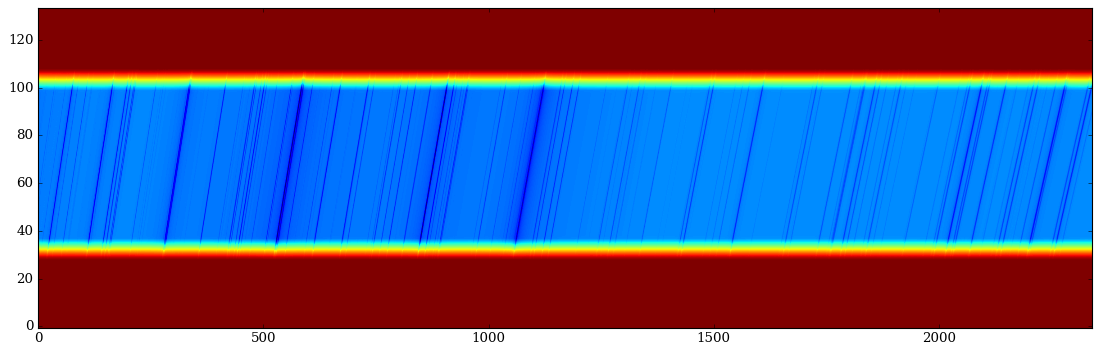

In [111]:
output_path = "./CC_output/WASP-121b/"
plt.figure(figsize=(17, 5))
plt.imshow(models_shifted, aspect="auto", origin="lower")
plt.savefig(output_path + "shifted_model.pdf", fmt="pdf")

In [112]:
models_shifted = (models_shifted.T / np.median(models_shifted, axis=1)).T
B = Bs[j]
model_filtered = models_shifted - B @ models_shifted

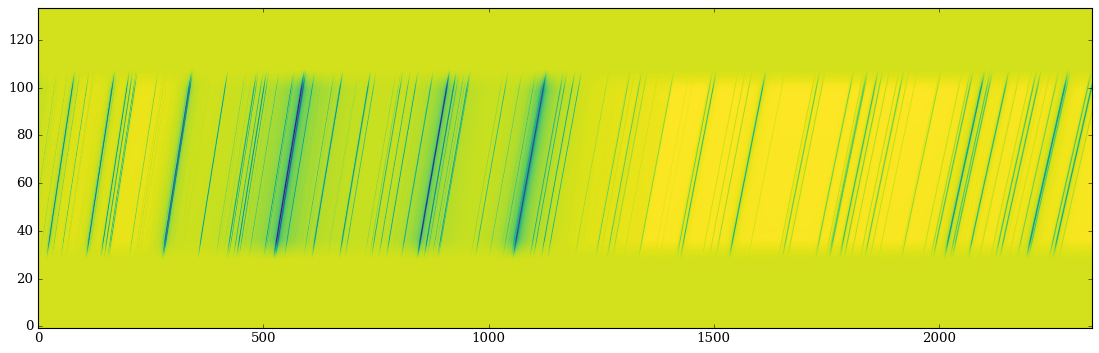

In [113]:
plt.figure(figsize=(17, 5))
plt.imshow(models_shifted, aspect="auto", origin="lower", cmap="viridis")
plt.savefig(output_path + "shifted_model_normalized.pdf", fmt="pdf")

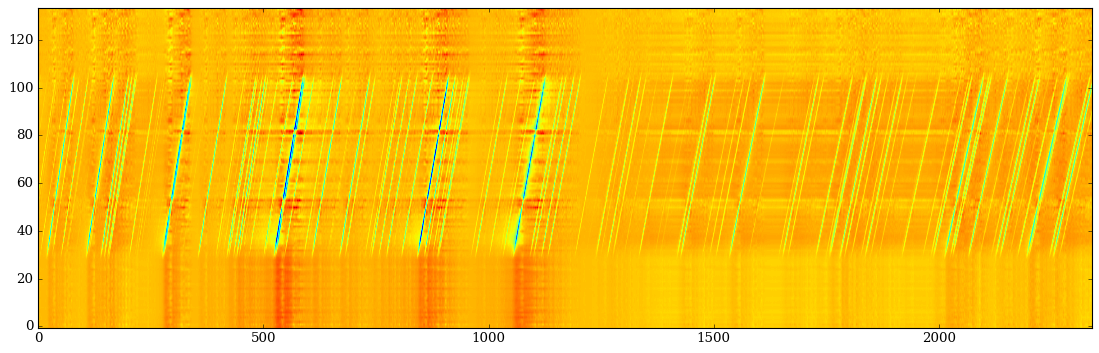

In [114]:
plt.figure(figsize=(17, 5))
plt.imshow(model_filtered, aspect="auto", origin="lower")
plt.savefig(output_path + "shifted_model_filtered.pdf", fmt="pdf")
# 如果不加入constant 1 basis vector会出现五彩斑斓，因为data经过preprocessing在time direction上数量级不变，basis vector主要account for continuum; 有1让basis vectors span数量级

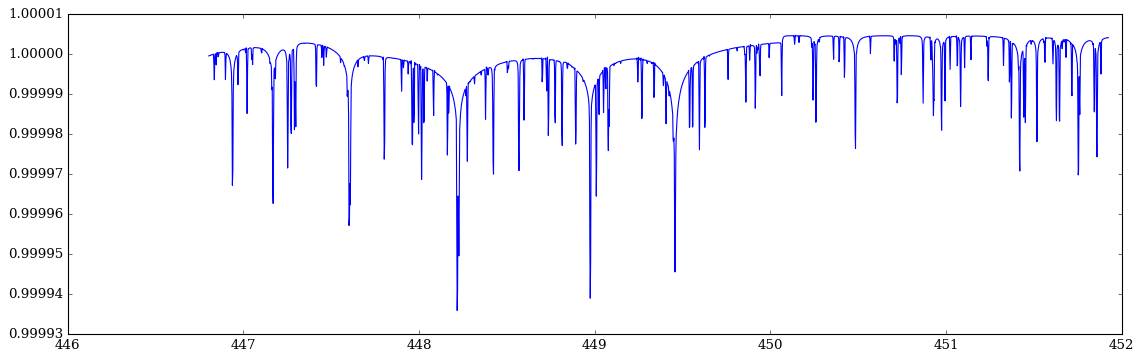

In [115]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[j] * 1000, models_shifted[70])
plt.ticklabel_format(useOffset=False)
plt.savefig(output_path + "shifted_model_0_50.pdf", fmt="pdf")

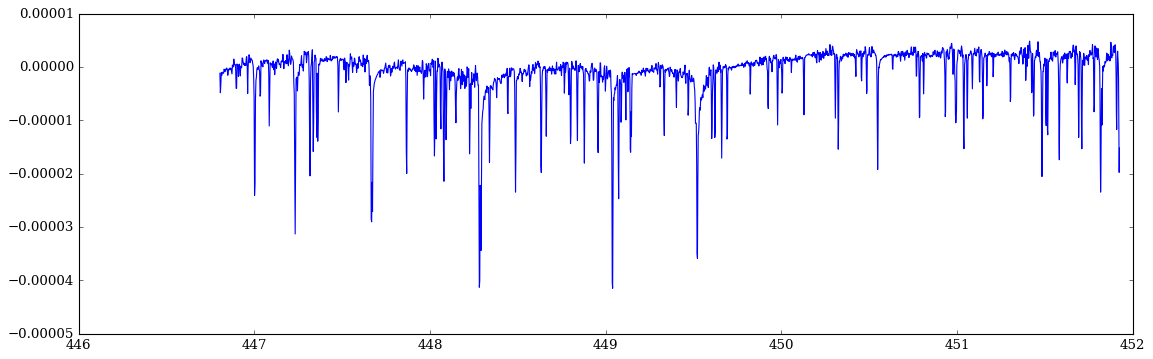

In [119]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[j] * 1000, model_filtered[100])
plt.ticklabel_format(useOffset=False)
plt.savefig(output_path + "filtered_model_0_50.pdf", fmt="pdf")

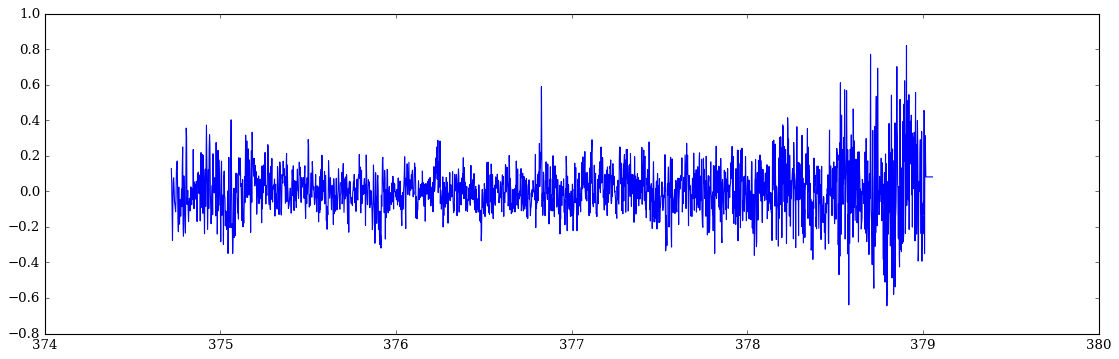

In [117]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[0] * 1000, residuals[0][50])
plt.ticklabel_format(useOffset=False)
plt.savefig(output_path + "residuals_0_50.pdf", fmt="pdf")